# <span style='color: blue'> **_Unveiling Ethereum's Price Dynamics: A Time Series Analysis and Forecasting_**</span> 

__Author__: _HACINI Ahmed Djalal_

#### Abstract
This study investigates the price movements of Ethereum, a prominent cryptocurrency, using time series analysis. We leverage a comprehensive dataset encompassing Ethereum's closing, opening, high, and low prices for a four-year period (2019-2022) with a 15-minute time interval. Employing ARIMA (Autoregressive Integrated Moving Average) models, we delve into model specification, fitting, and diagnosis. Subsequently, we utilize the chosen ARIMA model to generate forecasts for future Ethereum prices. By analyzing the results, this research aims to shed light on the underlying patterns and trends in Ethereum's price behavior. Furthermore, the forecasting component offers valuable insights for investors, traders, and businesses navigating the dynamic cryptocurrency market.


## **Introduction** ##

This project delves into the ever-changing world of **Ethereum prices**. Ethereum, a popular cryptocurrency, has experienced significant fluctuations in value since its inception. Understanding 
these price movements can be crucial for various stakeholders, including investors, traders, and businesses.

To facilitate this analysis, we've compiled a comprehensive **dataset** encompassing Ethereum's price history. This dataset specifically covers the years between __2019-11-27__ and __2022-03-16__, providing a detailed look at price movements over a four-year period.

The dataset offers granular details by capturing price data every __15 minutes__. This high frequency allows for a meticulous examination of even minor price shifts. With a total of __80,587 data points__, the dataset presents a substantial collection for researchers to explore.

Investigating Ethereum's price movements is worthwhile for several reasons. Firstly, understanding price fluctuations can inform investment decisions. By analyzing historical trends and patterns, investors can make more informed choices about buying, selling, or holding Ethereum.

Secondly, examining price movements can benefit businesses that accept Ethereum as payment. Recognizing potential price swings can help them prepare for fluctuations and make informed decisions regarding transactions.

Finally, this data can contribute to the development of more sophisticated trading models and algorithms. By incorporating historical price data, these models can potentially predict future price movements with greater accuracy, aiding traders in navigating the cryptocurrency market.

In essence, this dataset serves as a valuable tool for anyone interested in Ethereum's price behavior. By delving into this data, we can gain valuable insights into the cryptocurrency market and its potential future direction.


    Data Source:
 This dataset is sourced from Kaggle: https://www.kaggle.com/datasets/glebkirichenko/price-ethereum, a public platform for sharing and exploring machine learning datasets.

## **Analysis and Model Specification** ##

### Exploring the Data ###

First, lets load and take a first glance at the data

In [2]:
file_path <- "data/ETHUSDT_PERP_15m.csv"
data <- read.csv(file_path)
head(data)

,dateTime,open,high,low,close,volume
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-11-27 14:15:00,148.00,148.08,146.80,147.38,2693.24
2,2019-11-27 14:30:00,147.37,147.66,147.15,147.28,2355.46
3,2019-11-27 14:45:00,147.48,147.66,146.90,147.65,2584.54
4,2019-11-27 15:00:00,147.61,147.98,147.32,147.95,1876.29
5,2019-11-27 15:15:00,147.97,148.71,147.79,148.69,2407.68
6,2019-11-27 15:30:00,148.67,151.39,148.56,151.16,2471.09


We see that the names of the columns that are _Close, Open, High, and Low_ refer to the trading price of Ethereum over a specific period.

    Open: The price at which the first Ethereum trade occurred in the chosen timeframe (e.g., today, this week, this month).
    High: The highest price at which Ethereum was traded during the timeframe.
    Low: The lowest price at which Ethereum was traded during the timeframe.
    Close: The price at which the last Ethereum trade occurred within the timeframe.

For the purpose of the analysis, we would like to focus on __Close Price__ so that we can understand the final market sentiment and price after a trading session concludes.

In [3]:
# Keep only close price and timestamp columns and convert it to time series object
eth_data <- data[, c("dateTime", "close")]
dateTime <- strptime(eth_data$dateTime, "%Y-%m-%d %H:%M:%S")
eth_data <- ts(eth_data$close, start = c(2021, 1), frequency = 96)
head(eth_data)

[1] 147.38 147.28 147.65 147.95 148.69 151.16

In [4]:
# splitting the data into training and testing sets
train_size <- 0.8
train_size_index <- floor(train_size * length(eth_data))
train_data <- eth_data[1:train_size_index]
test_data <- eth_data[(train_size_index + 1):length(eth_data) ]

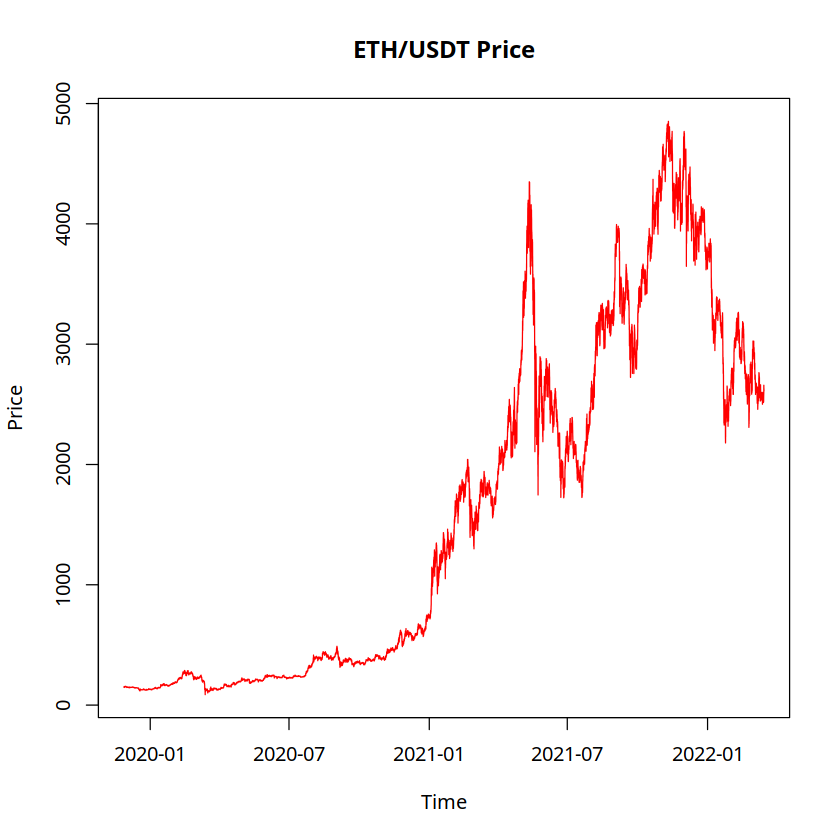

In [5]:
plot(y=eth_data, x= dateTime, type = "l", xlab = "Time", ylab = "Price", main = "ETH/USDT Price", col="red")

##### Interpreting the plot
The plot displays the price over time, showing significant movements within the intervals. There is an evident upward *__trend__* especially in the middle of the observed period where the price peaks. This *__trend__* suggests that the time series might not be *__stationary__*, as the statistical properties of the series, like the *__mean__* seems to be *__non-constant__* over time. Trend-stationarity would imply that fluctuations around a deterministic trend do not have a unit root, but this does not seem to be the case here (a statistical test will be conducted later).


The *__variance__* appears to be relatively *__small__*, but we haven't yet established if it's *__constant__* throughout the time series. Though, we can see some variation over time, although the changes aren't pronounced. This could suggest that while there is some fluctuation in the variance, it may not be substantial enough to deem the *__heteroscedasticity__*.

#### 

### Stationarity ###



Stationarity is a prerequisite for effective ARIMA modeling because it ensures that the model is built on a foundation where the underlying statistical properties do not change over time, allowing for more reliable and interpretable models and forecasts.

And since both ACF and PACF functions assume stationarity of the underlying time series. Staionarity can be checked by performing an *__Augmented Dickey-Fuller (ADF) test__*:

        p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
        p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


In order to check for stationarity, let's define a the following funtion that performs the ADF test:

In [ ]:
library(forecast)
library(tseries)
library(TSA)
library(ggplot2)
library(randtests)
library(nortest)

In [7]:
check_stationarity <- function(data) {
    result <- adf.test(data)
    cat('ADF Statistic:', result$statistic, '\n')
    cat("p-value", result$p.value, '\n')
    cat('Lag order:', result$parameter, '\n')
    if (result$p.value < 0.05 ) {
        cat('The data is stationary\n')
    } else {
        cat('The data is not stationary\n')
    }
}

In [8]:
check_stationarity(train_data)

ADF Statistic: -2.535115 
p-value 0.350788 
Lag order: 40 
The data is not stationary


*__p-value__*:
 The high p-value of 0.350788 signifies a failure to reject the null hypothesis at commonly used significance levels (0.05). This further bolsters the evidence for non-stationarity. Hence the visual inspection of *__non-stationarity__* in the time series plot aligns with the findings from the *__ADF test__*.

 _Note_: The *__Lag order__* of 40 might seem to be relatively high number of past values in the ADF regression model, but this is due to the fact that data lenght is quite large taking into consideration a 15min time frame. If we try to examine e.g 200 data points we will have a lag order of 5 which seems to be reasonable.

#### Differencing ####
To proceed with the analysis and generate reliable forecasts, it is crucial to address the non-stationarity issue. Common approaches include differencing to remove trends (detrending). By transforming the data to achieve stationarity, we can establish a more robust foundation for the analysis and produce more accurate forecasts of Ethereum prices.

$$\Delta y_t = y_t - y_{t-1}$$

In [9]:
# Checking the number of differences required to make the data stationary
print(ndiffs(train_data))

[1] 1


In [10]:
# As it suggests, we will take the first difference of the data
train_diff <- diff(train_data)

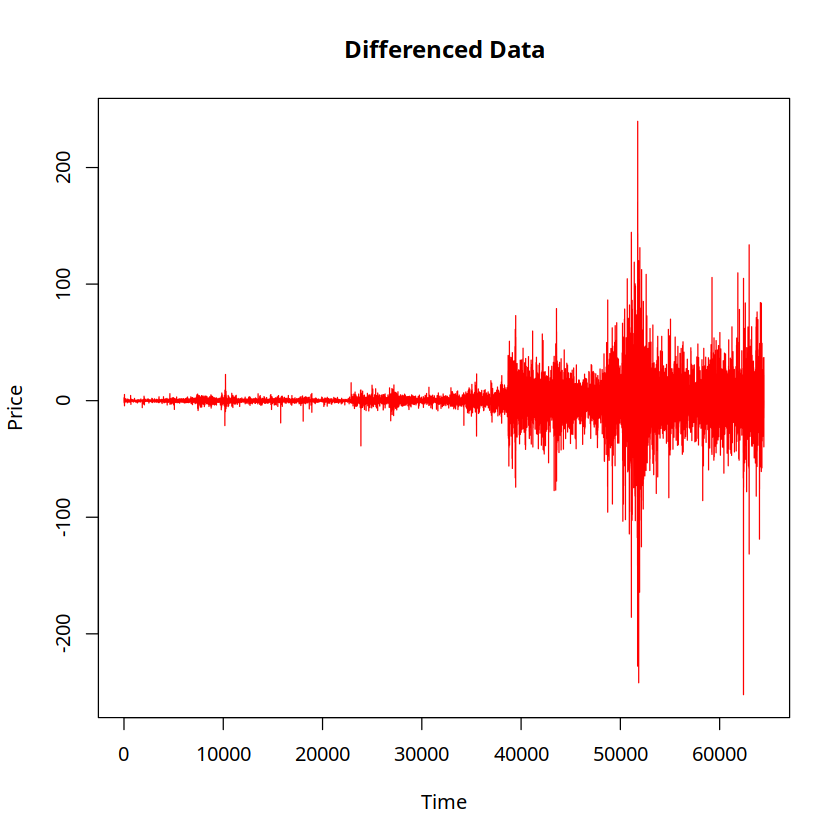

In [11]:
# Now, let's plot the differenced data and check if it is stationary
plot(train_diff, type = "l", xlab = "Time", ylab = "Price", main = "Differenced Data", col="red")

We can see that the 1st difference has removed the trend and brought our data to have a **zero mean**

However, the variance exhibists variations along the data points which indicates a *__heteroscedasticity__*.


#### Variance Stabilization ####
In time series, the process could have a non-constant variance and if the variance changes with time the process is nonstationary.
One common approach to suppress some of the variance is to use *__The Box-Cox transformation__* which is a family of power transformations indexed by a parameter lambda. Whenever we use this technique the parameter needs to be estimated from the data.
This technique must be applied even before taking the 1st difference to remove the trend.

$$y_t(\lambda) = 
\left\{
    \begin{array}{ll}
        \frac{y_t^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0, \\
        \log(y_t) & \text{if } \lambda = 0.
    \end{array}
\right.$$

In [12]:
λ <- BoxCox.lambda(train_data)
λ

[1] -0.008463963

In [13]:
#We transform both train and test data based on the best lambda value
trans_train <- BoxCox(train_data, λ)
trans_test <- BoxCox(test_data, λ)

Now after achieving a *__constant variance__* we can apply the differencing technique safely

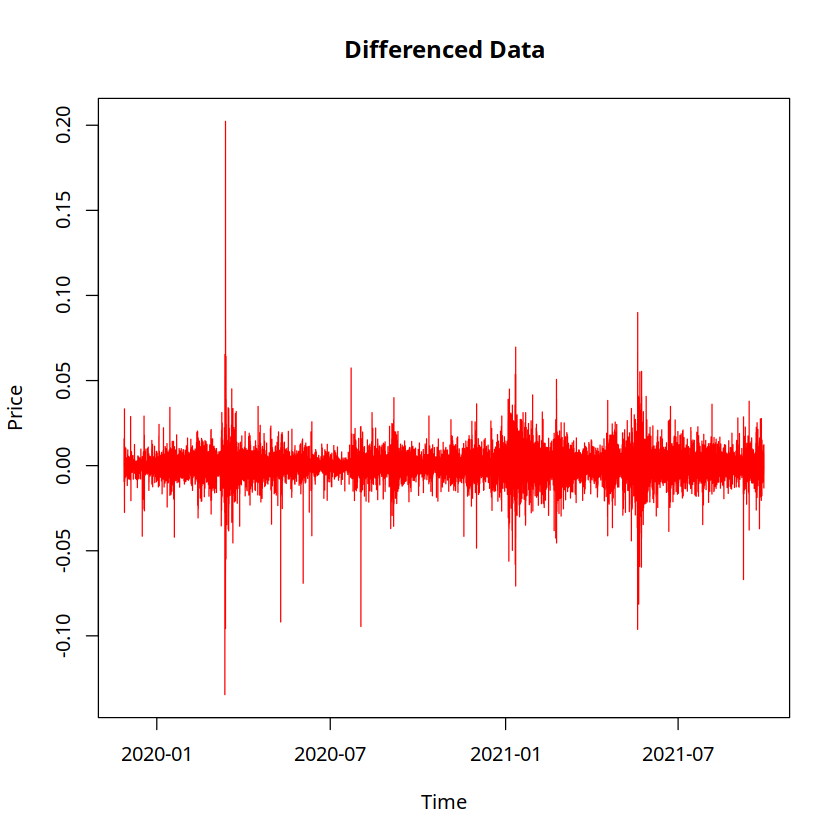

In [14]:
eth_train_data <- diff(trans_train)
plot(y=eth_train_data,x=dateTime[1:length(eth_train_data)], type = "l", xlab = "Time", ylab = "Price", main = "Differenced Data", col="red")

_Mean_: The differenced data seems to fluctuate around a mean of zero, which suggests that any trend present in the original data may have been removed by differencing.

_Variance_: The spikes in the plot, while pronounced, do not systematically increase or decrease in amplitude over time. This suggests that the variance is relatively stable, which is an indication that the Box-Cox transformation may have been effective.

_Outliers_: There are a few noticeable spikes, especially the one significant spike near the start around *__2020-03__*. These could be outliers or could represent significant one-time changes in the data (such as economic events for finincial data) which was actually the case with *__The COVID-19 pandemic__* that contributed to the rise of cryptocurrency by creating economic uncertainty and driving interest in alternative assets.

In [15]:
check_stationarity(eth_train_data)

Warning message in adf.test(data):
“p-value smaller than printed p-value”


ADF Statistic: -39.2674 
p-value 0.01 
Lag order: 40 
The data is stationary


Voilà !! The ADF test results a strong evidence of *__stationarity__* and the time series doesn't have any unit root. Hence, we can take the next step of selecting *__candidate models__* without any worries about model prameters bias.

### Model Parameters ###

For our *__ARIMA__* model with the equation:
$$ \phi(B)(1-B)^{d} Y_t = \theta(B)e_t$$

where where the AR and MA characteristic operators are: 

$$ \phi(B) = (1 - \phi_1B - \phi_2B² - ... \phi_pB^p) $$ 
$$ \theta(B) = (1 - \theta_1B - \theta_2B² - ... \theta_pB^q) $$ 

And the series of dth differences : 
$$ (1 - B)^d Y_t = \nabla^dY_t $$

The following table summerizes the behaviour of each model based on *ACF* and *PACF* functions

|      | AR(p)                    | MA(q)                             | ARMA(p, q)               |
|------|--------------------------|-----------------------------------|--------------------------|
| ACF  | Tails off (Geometric decay) | Significant at lag q / Cuts off after lag q | Tails off (Geometric decay) |
| PACF | Significant at each lag p / Cuts off after lag p | Tails off (Geometric decay) | Tails off (Geometric decay) |


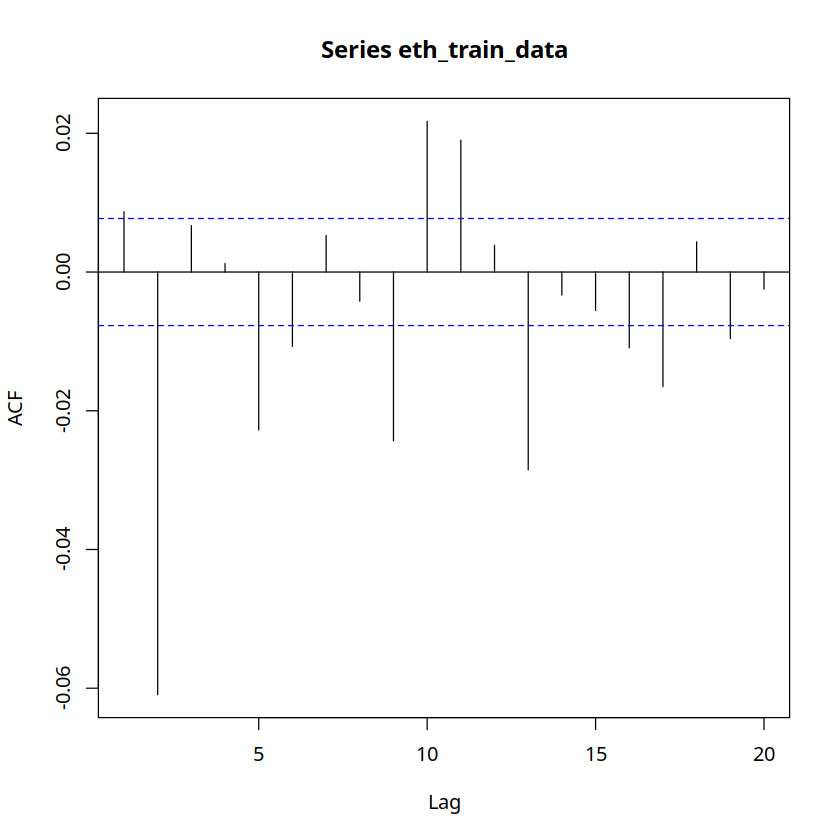

In [16]:
acf(eth_train_data, lag.max = 20)

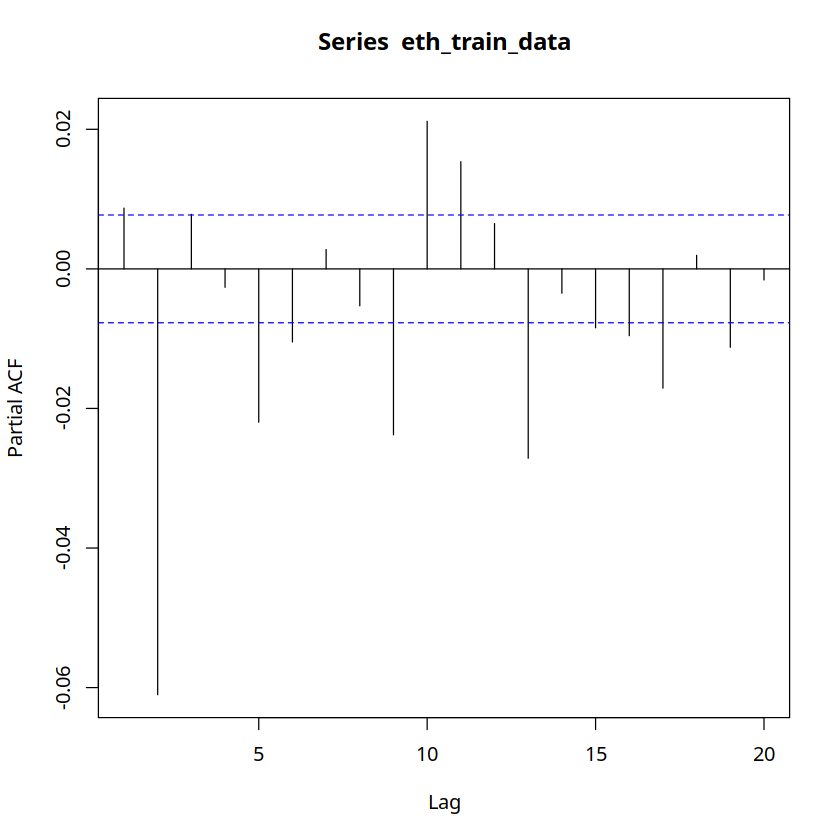

In [17]:
pacf(eth_train_data, lag.max = 20)

_Observations:_

**ACF Plot**

The ACF plot shows the correlation of the time series with its own lagged values. The ACF plot can be used to identify the MA(q) component of an ARIMA model. We can infer from the ACF plot:
The correlations are generally small and within the confidence bands, which is an indication that there may not be a strong MA component needed in the ARIMA model.The ACF tails off gradually, which could suggest an AR component is present.

**PACF Plot**

The PACF plot shows the partial correlation of the series with its own lagged values, PACF value at lag k is the autocorrelation between $X_t$ and $X_{t-k}$ that is not accounted for by lags $1$ through $k−1$. It can be used to identify the AR(p) component of an ARIMA model:
The partial autocorrelations are also within the confidence bands for most lags, which means that there's no significant evidence of a strong AR component.
The PACF cuts off after the first lag, which might suggest an AR(1) model could be considered.
**Best Parameters**

Based on the traditional use of these plots, one might conclude that an ARIMA model with low orders for both AR and MA components may be appropriate, something like $$ARIMA(p, d, q)$$ with $p = 1$ , $d$ determined by the number of differences required to achieve stationarity (which we previously found to be stationary, so $d=0$ but we can consider a model with $d=1$ fitted with _non differenced data_), and $q = 0$.

**Candidate 1: $ARIMA(1, 0, 0)$**

In [18]:
auto.arima(eth_train_data)

Series: eth_train_data 
ARIMA(2,0,1) with non-zero mean 

Coefficients:
          ar1     ar2     ma1  mean
      -0.1108  -0.060  0.1205     0
s.e.   0.0584   0.004  0.0584     0

sigma^2 = 2.972e-05:  log likelihood = 244523.6
AIC=-489037.2   AICc=-489037.2   BIC=-488991.9

`auto.arima` function returns best ARIMA model by conducting a search over the possible models and retrieve the appropriate on according to either AIC or BIC value.

**Candidate 2: $ ARIMA(2, 0, 1) $**

## **Fitting and Diagnostics** ##

In [19]:
arima_model.1 <- Arima(eth_train_data, order = c(2, 0, 1))
summary(arima_model.1)

Series: eth_train_data 
ARIMA(2,0,1) with non-zero mean 

Coefficients:
          ar1     ar2     ma1  mean
      -0.1108  -0.060  0.1205     0
s.e.   0.0584   0.004  0.0584     0

sigma^2 = 2.972e-05:  log likelihood = 244523.6
AIC=-489037.2   AICc=-489037.2   BIC=-488991.9

Training set error measures:
                       ME        RMSE         MAE MPE MAPE      MASE
Training set 2.196062e-08 0.005451392 0.003335922 NaN  Inf 0.6891592
                     ACF1
Training set 6.559451e-06

In [33]:
arima_model.2 <- Arima(eth_train_data, order = c(1, 0, 0))
summary(arima_model.2)

Series: eth_train_data 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1  mean
      0.0087     0
s.e.  0.0039     0

sigma^2 = 2.983e-05:  log likelihood = 244401.5
AIC=-488796.9   AICc=-488796.9   BIC=-488769.7

Training set error measures:
                        ME        RMSE         MAE MPE MAPE      MASE
Training set -5.149272e-11 0.005461732 0.003346195 NaN  Inf 0.6912814
                     ACF1
Training set 0.0005311691

### Interpreting the models estimators ###



First, let's give a brief explanation of the Metrics:


**sigma² (Variance of Residuals):**

Sigma² is an estimate of the variance of the residuals or errors of the model. It represents the square of the standard deviation of the residuals. A lower sigma² indicates a model that more closely fits the data.


**Log Likelihood $L$:**

The log likelihood measures how well the model fits the data; it's the logarithm of the likelihood function for the fitted model. When maximizing $L$ with respect to model parameters, we
find values that are most consistent with the observed data.

**Akaike Information Criterion (AIC):**

The AIC is a metric used for model selection among a set of models. It takes into account the goodness of fit (via the log likelihood) and the number of parameters used in the model. The goal is to select a model that best explains the data with the least number of parameters. Lower AIC values indicate a preferable model.
$$ AIC = -2ln(L) + 2k $$

**Bayesian Information Criterion (BIC):**

Similar to AIC, the BIC also penalizes the number of parameters used, but it applies a stricter penalty based on the sample size. Like AIC, a lower BIC suggests a better model.
$$ BIC = -2ln(L) + kln(n) $$

Considering the above points, ***$ARIMA(2,0,1)$*** is the better model among the two as it has a better fit (higher log likelihood) and is more efficient in explaining the data (lower AIC and BIC)

### Residuals Analysis ###
Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In [21]:
rsds <- arima_model.1$residuals
std.resids <- rsds - mean(rsds)/sd(rsds)

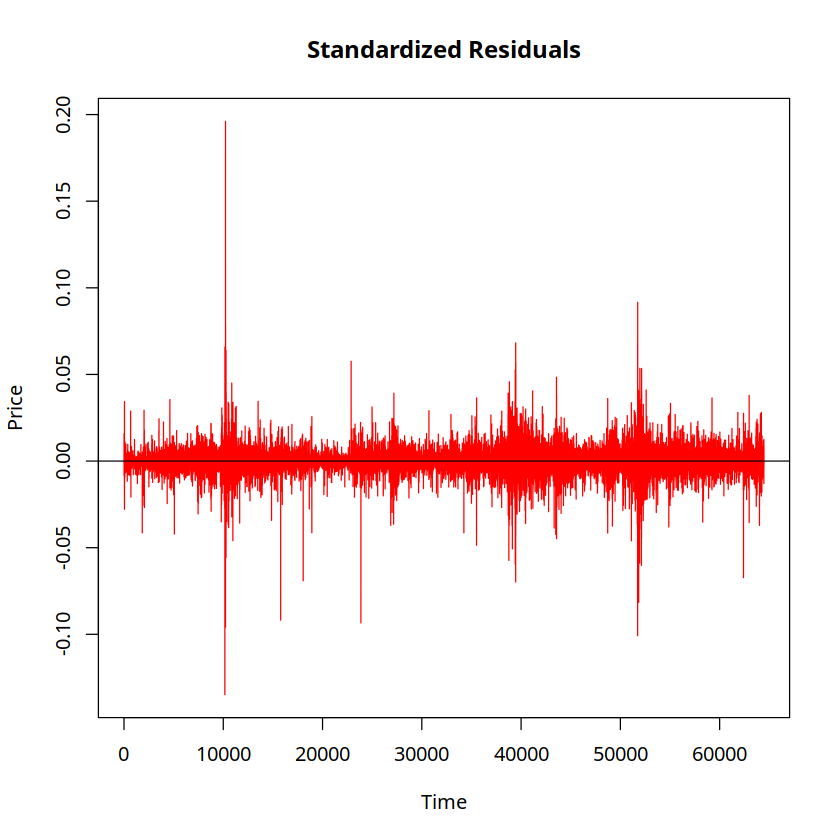

logical(0)

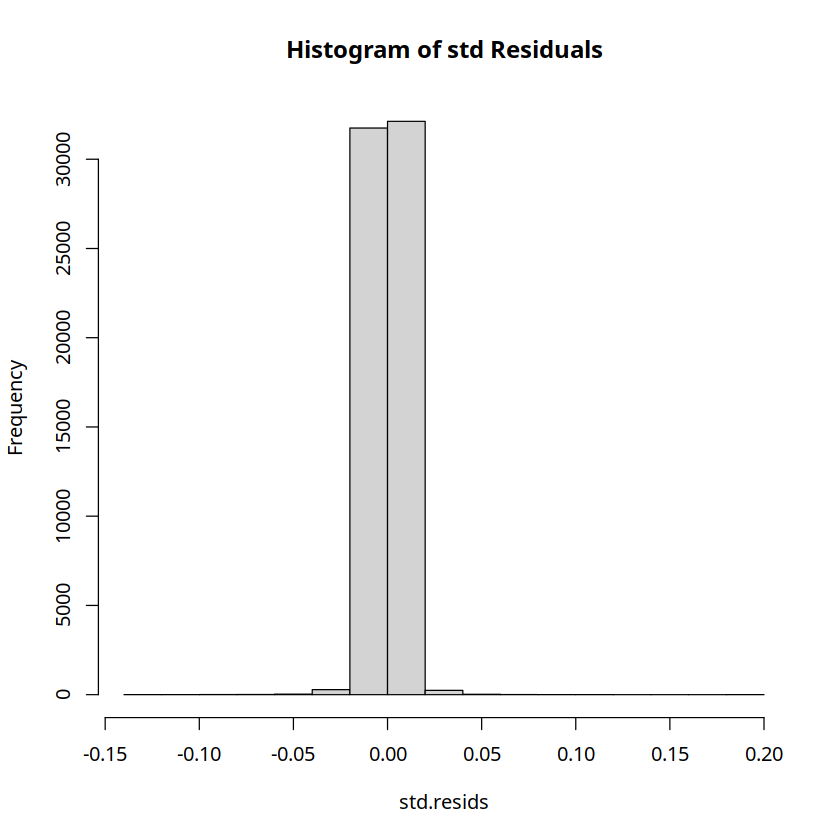

In [22]:
#plotting the residuals
plot(std.resids, type = "l", xlab = "Time", ylab = "Price", main = "Standardized Residuals", col="red")
abline(h=0) > hist(std.resids, main="Histogram of std Residuals")
options(repr.plot.width=10, repr.plot.height=8)

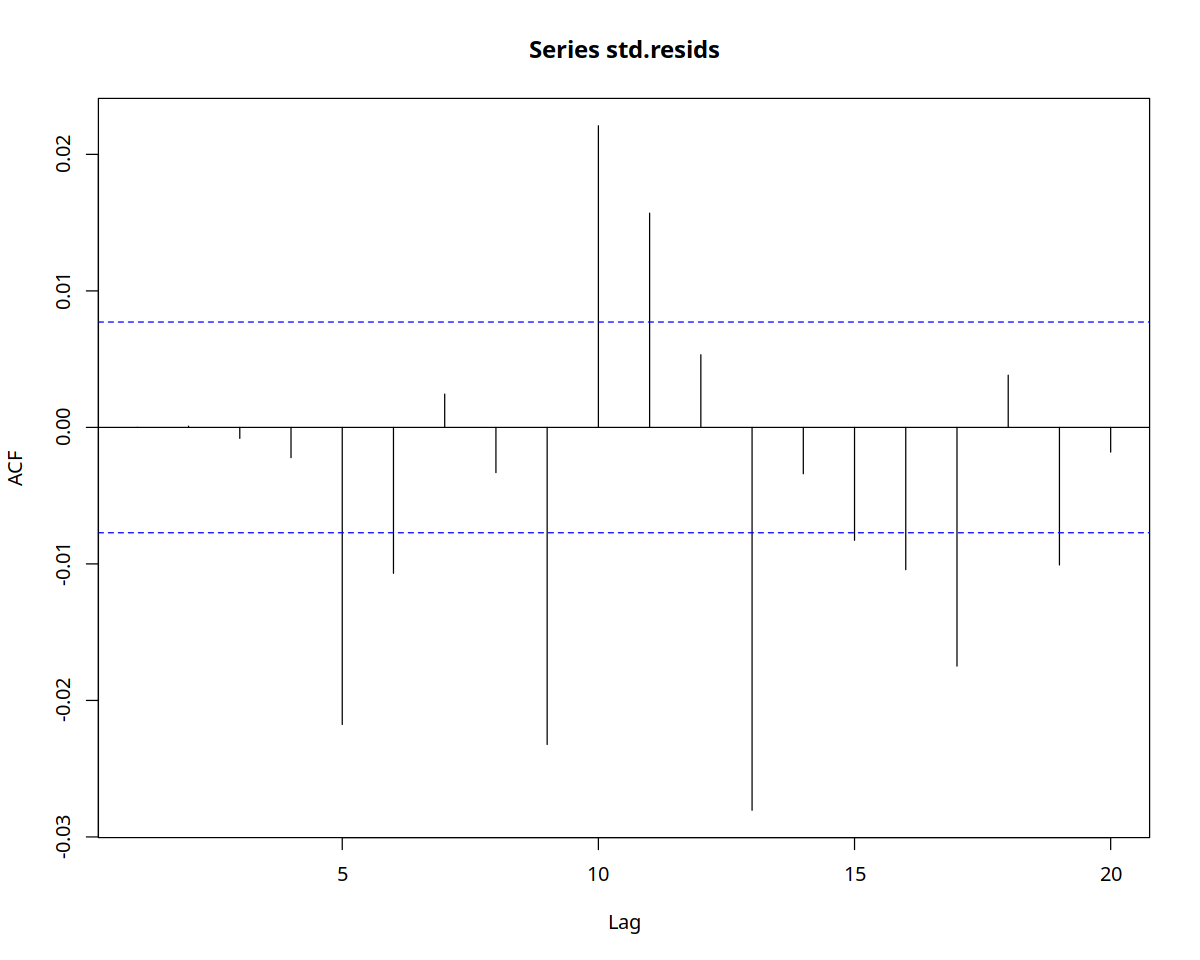

In [23]:
acf(std.resids, lag.max = 20)

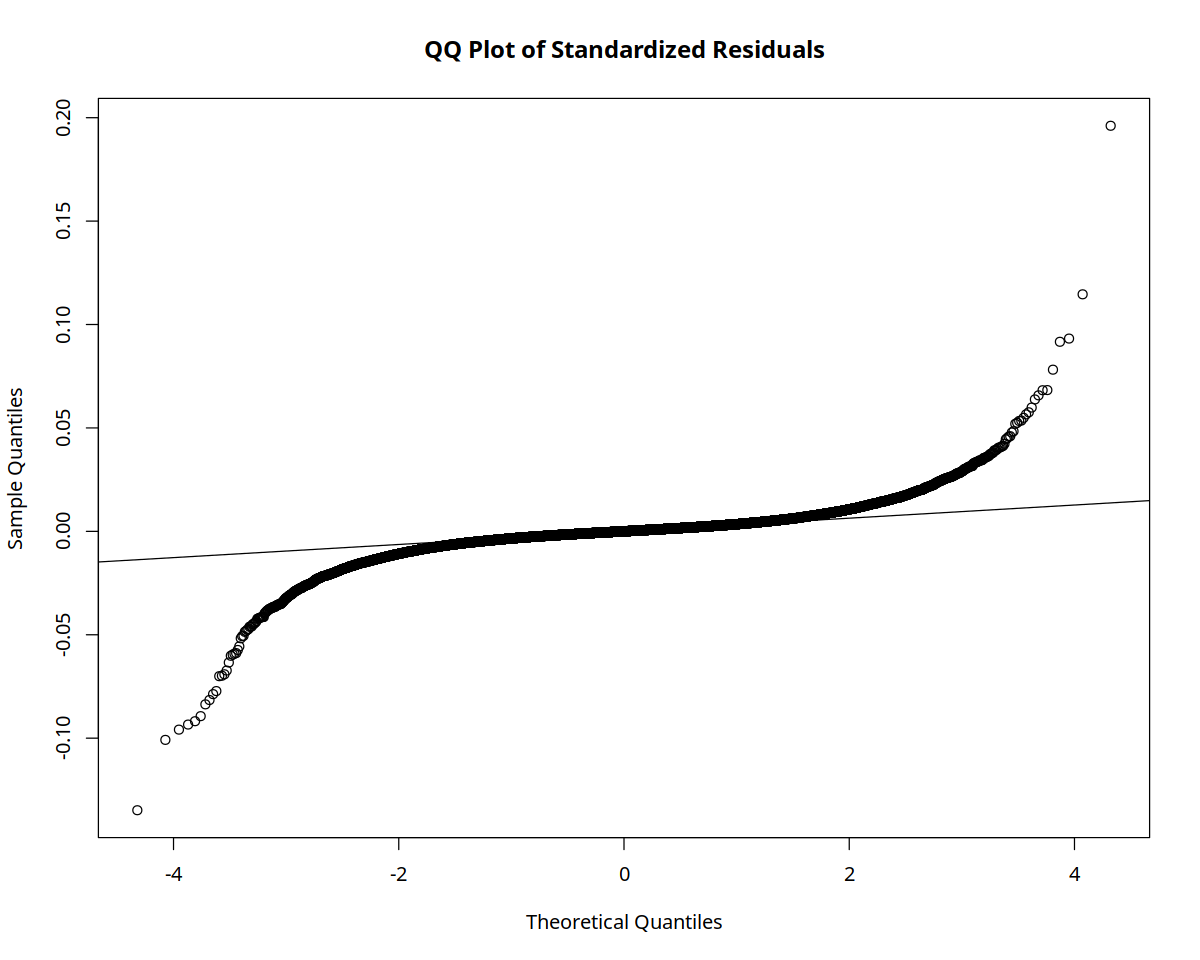

In [24]:
qqnorm(std.resids, main= "QQ Plot of Standardized Residuals")
qqline(std.resids)

In [25]:
#perform shapiro test of normality
shapiro.test(std.resids[1:5000])


	Shapiro-Wilk normality test

data:  std.resids[1:5000]
W = 0.83329, p-value < 2.2e-16


In [26]:
#Shapiro test only works for up to 5000 observations, so we will use the Anderson-Darling test
ad.test(std.resids)


	Anderson-Darling normality test

data:  std.resids
A = 1956.9, p-value < 2.2e-16


In [27]:
runs.test((std.resids))


	Runs Test

data:  (std.resids)
statistic = 14.163, runs = 34033, n1 = 32234, n2 = 32234, n = 64468,
p-value < 2.2e-16
alternative hypothesis: nonrandomness


#### Interpreting the results 

**Histogram of Standardized Residuals:**

The histogram shows the distribution of standardized residuals from the ARIMA model. Ideally, we would want to see a bell-shaped curve characteristic of a normal distribution. However, the histogram seems to be highly concentrated around zero, suggesting that the residuals might not be normally distributed.


**ACF Plot of Standardized Residuals:**

For a well-fitting ARIMA model, we would expect most autocorrelations to be within the confidence bounds (statistically being zero), suggesting that there is no autocorrelation in the residuals. However, the ACF plot you shows some significant spikes outside the confidence interval alternating between positive and negative. This may indicate that the model has not fully captured the autocorrelation in the data, and there is still some seasonal structure left to explain.


**QQ Plot of Standardized Residuals:**

A QQ plot compares the quantiles of the residuals to the quantiles of a normal distribution. In a well-fitting model, the points should lie approximately along the 45-degree line. But we see clear deviations from the line, especially at the tails. This is evidence that the residuals are not normally distributed, and there might be outliers or heavy tails that the model does not account for.


**Anderson-Darling Test:**

The result of the Anderson-Darling test with a very high test statistic (A = 1956.9) and a p-value effectively at zero suggests that we can reject the null hypothesis of normality. This indicates that the residuals do not follow a normal distribution, which supports the visual interpretation. 


**Runs Test:**

The very low p-value (< 2.2e-16) from Runs test rejects the null hypothesis of independence. This suggests that the residuals are not random, indicating that the ARIMA model may not be adequately capturing all the patterns in the data.

## **Forecasting** ##
Having successfully addressed the non-stationarity in our Ethereum price data, we can now proceed to the forecasting stage. This stage involves utilizing our candidate models to predict future price movements

In [34]:
print("Number of instances to be predicted is:")
length(trans_test)

[1] "Number of instances to be predicted is:"


[1] 16118

In [29]:
#forecast data using ARIMA(2,0,1) model
arima_2.0.1_preds <- forecast(arima_model.1)

In [35]:
#forecast data using ARIMA(2,0,2) model
arima_1.0.0_preds <- forecast(arima_model.2)

In [31]:
# Applying the same Box-Cox transformation to the original data to see the forecast
eth_data_ts <- BoxCox(eth_data, lambda=λ)

In [36]:
accuracy((arima_2.0.1_preds), ts(eth_data_ts))
accuracy((arima_1.0.0_preds), ts(eth_data_ts))

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,2.196062e-08,0.005451392,0.003335922,NaN,Inf,0.6891592,6.559451e-06,NA
Test set,7.708438e+00,7.708440281,7.708438172,99.99935,99.99935,1592.4655637,5.470346e-01,1851.631


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-5.149272e-11,0.005461732,0.003346195,NaN,Inf,0.6912814,0.0005311691,NA
Test set,7.708444e+00,7.708446496,7.708444397,99.99944,99.99944,1592.4668497,0.5474887594,1851.631


**ME (Mean Error)**: This is the average of the residuals (errors) across all predictions. For the training set, the ME is very close to zero, which is good. However, for the test set, the ME is significantly higher, indicating that on average, the forecasts are off by a considerable amount in one direction.
The significant differences in error metrics between the training and test sets suggest the model may not generalize well to new data.



## **Discussion and Conclusion** ##

In our project, we aimed to analyse and forecast Ethereum Price time series using ARIMA models. Initially, we faced the challenge of making the data stationary, which involved detrending and stabilizing the variance. After fitting several ARIMA models, we relied on AIC and BIC metrics to choose the best-performing model.

However, residual diagnostics revealed two main issues: the residuals were not normally distributed, and there was evidence of autocorrelation, suggesting that important information in the data was not captured by the model. This led to the conclusion that while ARIMA models are useful, they may not be sufficient for this particular dataset.

To improve our forecasts, we suggest exploring SARIMA models to account for seasonality, considering models for non-linear relationships and heavy-tailed distributions, and possibly integrating machine learning techniques. These steps could help address the shortcomings of the standard ARIMA approach and lead to better predictive performance.